![Winsconsin](img/winsconsin.jpeg)

🩻 **Classification de tumeurs à partir de données médicales**

**Contexte** :
Vous intégrez une équipe de développement en intelligence artificielle dans le cadre d’un projet pilote mené par un consortium de recherche médicale basé dans l’État du Wisconsin, aux États-Unis. Ce projet vise à concevoir des outils numériques d’aide au diagnostic précoce du cancer du sein, en collaboration avec des centres hospitaliers universitaires et des laboratoires d’analyses.

Dans ce cadre, un jeu de données clinique réel — le **Breast Cancer Wisconsin Diagnostic Dataset**, collecté par le Dr. William H. Wolberg au sein de l’université du Wisconsin — a été mis à disposition. Ce dataset contient les caractéristiques de cellules prélevées lors de biopsies mammaires, classées manuellement comme tumeurs bénignes ou malignes.

⸻

🎯 **Objectif** :

Votre mission consiste à concevoir un prototype fonctionnel permettant de prédire la nature de la tumeur à partir de ces données, via un modèle de classification en apprentissage supervisé ([**régression logistique**](https://www.w3schools.com/python/python_ml_logistic_regression.asp)). L’objectif est de démontrer la faisabilité d’un outil automatisé pouvant compléter l’expertise des médecins dans l’analyse de résultats de biopsies.

Construire un modèle de régression logistique capable de prédire la variable `diagnosis` à partir des caractéristiques disponibles dans le fichier ([`data/breast_cancer_wisconsin.csv`](data/breast_cancer_wisconsin.csv)).  

Pour comprendre le dataset, vous pouvez consulter cette page kaggle : https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

- Exploration des données (EDA) :
    - Comprendre les variables (qualitatives/quantitatives)
	- Statistiques descriptives
	- Visualisations (histogrammes, heatmap de corrélation, etc.)
- Préparation des données :
    - Traitement des valeurs manquantes sinécessaire
	- **Transformation des variables catégorielles** (`diagnosis`)
	- **Création éventuelle de nouvelles features**
	- Standardisation si nécessaire
    - Séparation train/test
- Modélisation :
    - Implémentation d’un modèle de régression logistique
- Évaluation du modèle :
    - Calcul des métriques : accuracy, precision, recall, f1-score
    - Matrice de confusion 
    - Bonus : [Étudier AUC - ROC curve](https://www.w3schools.com/python/python_ml_auc_roc.asp)
- Intégration simple du modèle dans un script interactif
    - Intégrer votre modèle dans un script Python simple qui permet à un utilisateur de faire une prédiction à partir de nouvelles données.

⚠️ Attention aux variables fortement corrélées

Le jeu de données Breast Cancer Wisconsin contient plusieurs variables fortement corrélées entre elles, notamment :
- `radius_mean`, `perimeter_mean`, `area_mean`
- ainsi que leurs déclinaisons en `_se` et `_worst`

Cela peut poser des problèmes de multicolinéarité, particulièrement si vous utilisez des modèles linéaires (régression logistique, SVM linéaire, etc.). Ces redondances peuvent fausser les résultats ou générer un sur-apprentissage.

➤ Recommandations :
- Identifiez les corrélations fortes à l’aide d’une matrice de corrélation ou d’une heatmap
- En cas de corrélation > 0.9 entre deux variables, conservez une seule variable du groupe
- Bonus (niveau légende 😈) : vous pouvez également étudier et appliquer une [réduction de dimension type PCA (Pricipal Component Analysis)](https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-de-donnees-exploratoire/5280368-comprenez-lenjeu-de-lanalyse-en-composantes-principales) si vous souhaitez automatiser le traitement de la redondance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
import joblib

In [ ]:
df = pd.read_csv('data/breast_cancer_wisconsin.csv')

In [ ]:
df.head(15)

## on observe que la dataset et composé de 569 lignes et les colonnes ne présente pas de valeur null
### le dataset est composé de 31 colonnes. il faut analyser celle qui sont pertinante, celle qui présente des données contre productif et adapter la solution en fonction de chacun des cas

In [ ]:
%%sql


In [ ]:
df.info()

## la première lecture de describe

### suppression de la colonne de l'id qui n'est pas pertinant pour notre annalyse

In [ ]:
df.describe()

In [ ]:
df = df.drop(["id"], axis=1)

In [ ]:
df.head(15)

### Traitement des valeurs à zéro
### on transforme en valeur NaN afin de pouvoir ensuite prendre la médian et insérer celle-çi
##### attention il ne faut pas prendre en compte diagnosis car cette colonne est de type objet. elle renvoie donc O ou 1 pour M & B

In [ ]:
# Sélectionner les colonnes où le minimum est 0
colonnes_min_zero = [col for col in df.columns if df[col].min() == 0]

# Afficher la liste des colonnes
print(colonnes_min_zero)

##### on constate que le % de detection avec des valeur maligne ou benigne sont différents

In [ ]:
df["diagnosis"].value_counts()


In [ ]:
cols_with_zero_invalid = ["concavity_mean", "concave points_mean", "concavity_se", "concave points_se", "concavity_worst", "concave points_worst"]
df[cols_with_zero_invalid] = df[cols_with_zero_invalid].replace(0, np.nan)

for col in cols_with_zero_invalid:
    df[col] = df[col].fillna(df[col].median())

In [ ]:
df.describe()

In [ ]:
# Sélectionner les colonnes où le minimum est 0
colonnes_min_zero = [col for col in df.columns if df[col].min() == 0]

# Afficher la liste des colonnes
print(colonnes_min_zero)

##### indication si tumeur maligne ou bégnine
##### il faut équilibrer les classes afin d'obtenir des résultats qui ne sont pas influencer par une valeur supérrieur à l'autre

In [ ]:
sns.countplot(x=df["diagnosis"], data=df)
plt.title("Répartition des classes")
plt.grid(True, axis="y")
plt.show()

In [ ]:
df.shape

In [ ]:
cols = df.columns.drop("diagnosis")

plt.figure(figsize=(15,15))
for i, col in enumerate(cols, 1):
    plt.subplot(5, 7, i)
    sns.histplot(df[col], bins=20)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


## La mise en évidence pour des cas de tumeur maligne
#### les graphiques qui une prédominance pour mettre en évidence les risque de tumeur sont :
##### radius_mean, texture_mean, perimeter_mean, area_mean, compactness_mean, concavity_mean, concave points_mean, radius_se, perimeter_se, area_se, concave points_se, radius_worst, texture_worst, perimeter_worst, area_worst, smooothness_worst, compactness_worst, concavity_worst, concave points_worst, simmetry_worst, fractial_dimension_worst

#####

In [ ]:
cols = df.columns.drop("diagnosis")

plt.figure(figsize=(24,24))
for i, col in enumerate(cols, 1):
    plt.subplot(5, 7, i)
    sns.histplot(data=df, x=col, hue="diagnosis", kde=True)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


##### on peux constater que des valeur abérante sont présente. Ils faut donc les traiter pour avoir un meilleur jeu de test

In [ ]:
for col in df.columns:
    plt.figure(figsize=(5,3))
    sns.boxplot(df[col], color='blue')
    plt.title(f"{col} Boxplot")
    plt.show()

##### traitement par une méthode pour supprimer les outliers

In [ ]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (
        lower_bound,
        upper_bound,
        df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        )

In [ ]:
df_cleaned = df.copy()
for column in df_cleaned.select_dtypes(include=["number"]).columns:
    lower_bound, upper_bound, outliers = detect_outliers(df_cleaned, column)
    df_cleaned = df_cleaned[~df_cleaned.index.isin(outliers.index)]

df = df_cleaned

In [ ]:
for col in df.columns:
    plt.figure(figsize=(5,3))
    sns.boxplot(df[col], color='blue')
    plt.title(f"{col} Boxplot")
    plt.show()
print(df["diagnosis"])

In [ ]:
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [ ]:
df_numeric = df.select_dtypes(include=["number"])

if df_numeric.empty:
    raise ValueError("Le DataFrame est vide après sélection des types numériques.")

corr_matrix = df_numeric.corr().fillna(0)

# Filtrer les colonnes ayant une corrélation absolue > 0.9 avec "diagnosis"
target_corr = corr_matrix["diagnosis"].abs()
columns_to_keep = target_corr[target_corr > 0.95].index

# Ajouter les colonnes qui sont fortement corrélées entre elles (> 0.9)
high_corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.95]
high_corr_pairs = high_corr_pairs[high_corr_pairs.index.get_level_values(0) != high_corr_pairs.index.get_level_values(1)]

additional_columns = set(high_corr_pairs.index.get_level_values(0)).union(set(high_corr_pairs.index.get_level_values(1)))

# Fusionner les colonnes à garder
columns_to_keep = columns_to_keep.union(additional_columns)

df_filtered = df_numeric[list(columns_to_keep)]

print("Colonnes conservées :", df_filtered.columns)

plt.figure(figsize=(25, 10))
sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Filtered > 0.9 with Diagnosis)")
plt.show()



In [ ]:
X = df[[col for col in df.columns if col != "diagnosis"]]
y = df["diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df = df

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = LogisticRegression(solver="liblinear", class_weight="balanced")
model.fit(X_train_scaled, y_train)

In [ ]:
y_pred = model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True)
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.title("Matrice de confusion")
plt.show()

In [ ]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred))
print("Recall :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))

In [ ]:
import os

os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/logistic_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
import joblib
df2 = pd.read_csv('data/breast_cancer_wisconsin.csv')


In [72]:
print(df2.columns)

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [73]:
# Supprime la colonne "id" du DataFrame, car elle est un identifiant unique et ne contribue pas à l'analyse.
df2 = df2.drop(["id"], axis=1)

# Convertit la colonne "diagnosis" en valeurs numériques :
# "M" (Malignant) devient 1 et "B" (Benign) devient 0, ce qui permet d'utiliser ces valeurs dans des algorithmes de Machine Learning.
df2['diagnosis'] = df2['diagnosis'].map({'M': 1, 'B': 0})


In [74]:
# Sélectionne toutes les colonnes sauf les deux premières et les convertit en un tableau NumPy.
# Cela signifie que l'on prend uniquement les caractéristiques pour l'entraînement du modèle.
X = df2.iloc[:, 2:].values

# Sélectionne la première colonne, qui contient les labels ('diagnosis'), et la convertit en un tableau NumPy.
# Cette colonne contient les valeurs 0 et 1 (tumeurs bénignes et malignes).
y = df2.iloc[:, 0].values


In [75]:
print(df2.shape)

(569, 31)


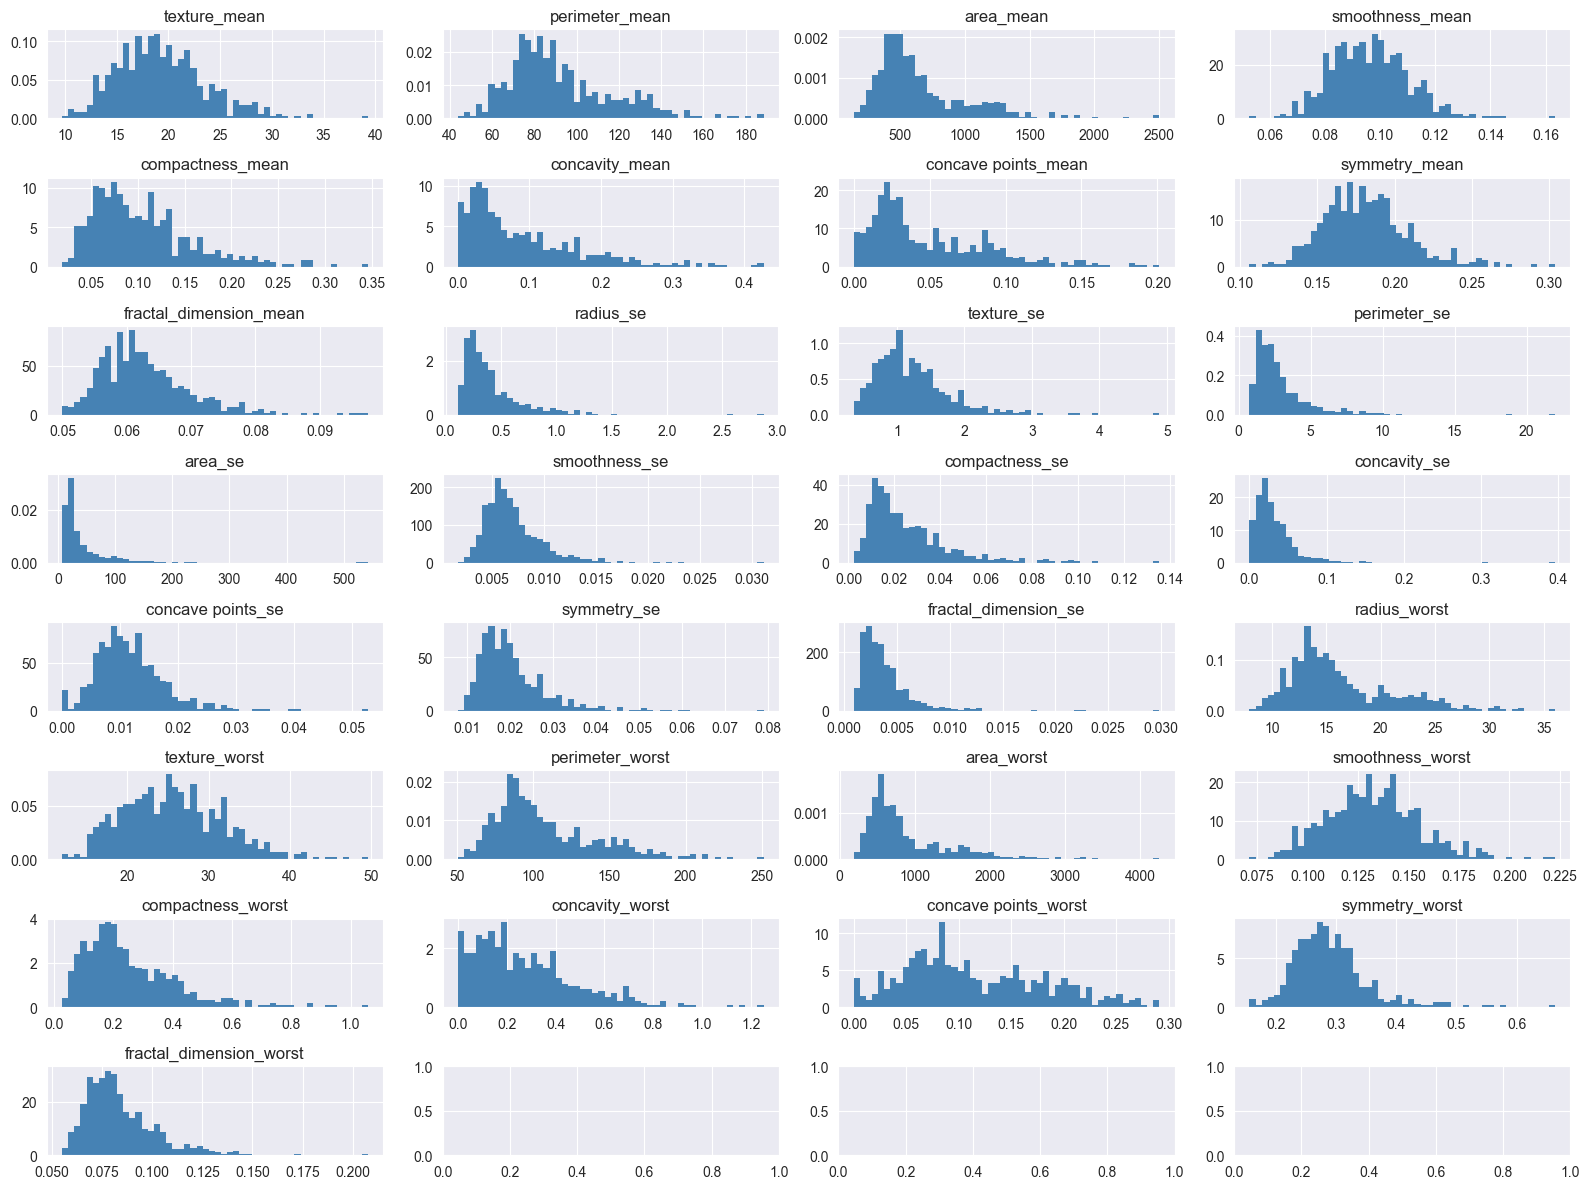

In [94]:
import matplotlib.pyplot as plt

# Création d'une figure avec plusieurs sous-graphiques disposés en plusieurs lignes et 4 colonnes.
# Le nombre de lignes est calculé dynamiquement pour s'adapter au nombre de colonnes dans X.
fig, axes = plt.subplots((X.shape[1] + 3) // 4, 4, figsize=(16, 12))

# `axes` est initialement une matrice 2D contenant les sous-graphiques.
# La méthode `.flatten()` transforme cette matrice en une liste 1D pour faciliter l'accès aux axes.
# Evite les erreur d'indexation => si on veux acceder à une valeur non présente dans la matrice 1D
axes = axes.flatten()

# Boucle à travers toutes les colonnes de X pour tracer un histogramme de leurs valeurs.
for feat_idx in range(X.shape[1]):
    ax = axes[feat_idx]  # Sélectionne le subplot correspondant dans la liste 1D `axes`
    ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')  # Histogramme de la colonne
    ax.set_title(df2.columns[feat_idx + 2])  # Ajoute le titre correspondant à la colonne

# Ajuste automatiquement l'affichage pour éviter le chevauchement des graphiques
plt.tight_layout()
plt.show()


In [98]:
# Divise les données en un ensemble d'entraînement et un ensemble de test.
# La variable `test_size=0.2` signifie que 20% des données seront utilisées pour les tests et 80% pour l'entraînement.
# `random_state=42` garantit que la séparation des données est reproductible à chaque exécution.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)


In [99]:
# Initialise un standardiseur de variables (`StandardScaler`) qui va normaliser les données.
# `.fit(X_train)` calcule la moyenne et l'écart-type pour chaque caractéristique de `X_train`.
std_scale = preprocessing.StandardScaler().fit(X_train)

# Applique la transformation de normalisation à `X_train`.
# Chaque caractéristique est transformée en ayant une moyenne de 0 et un écart-type de 1.
X_train_std = std_scale.transform(X_train)

# Applique la même transformation à `X_test`, en utilisant les statistiques de `X_train` pour garantir une cohérence des échelles.
X_test_std = std_scale.transform(X_test)


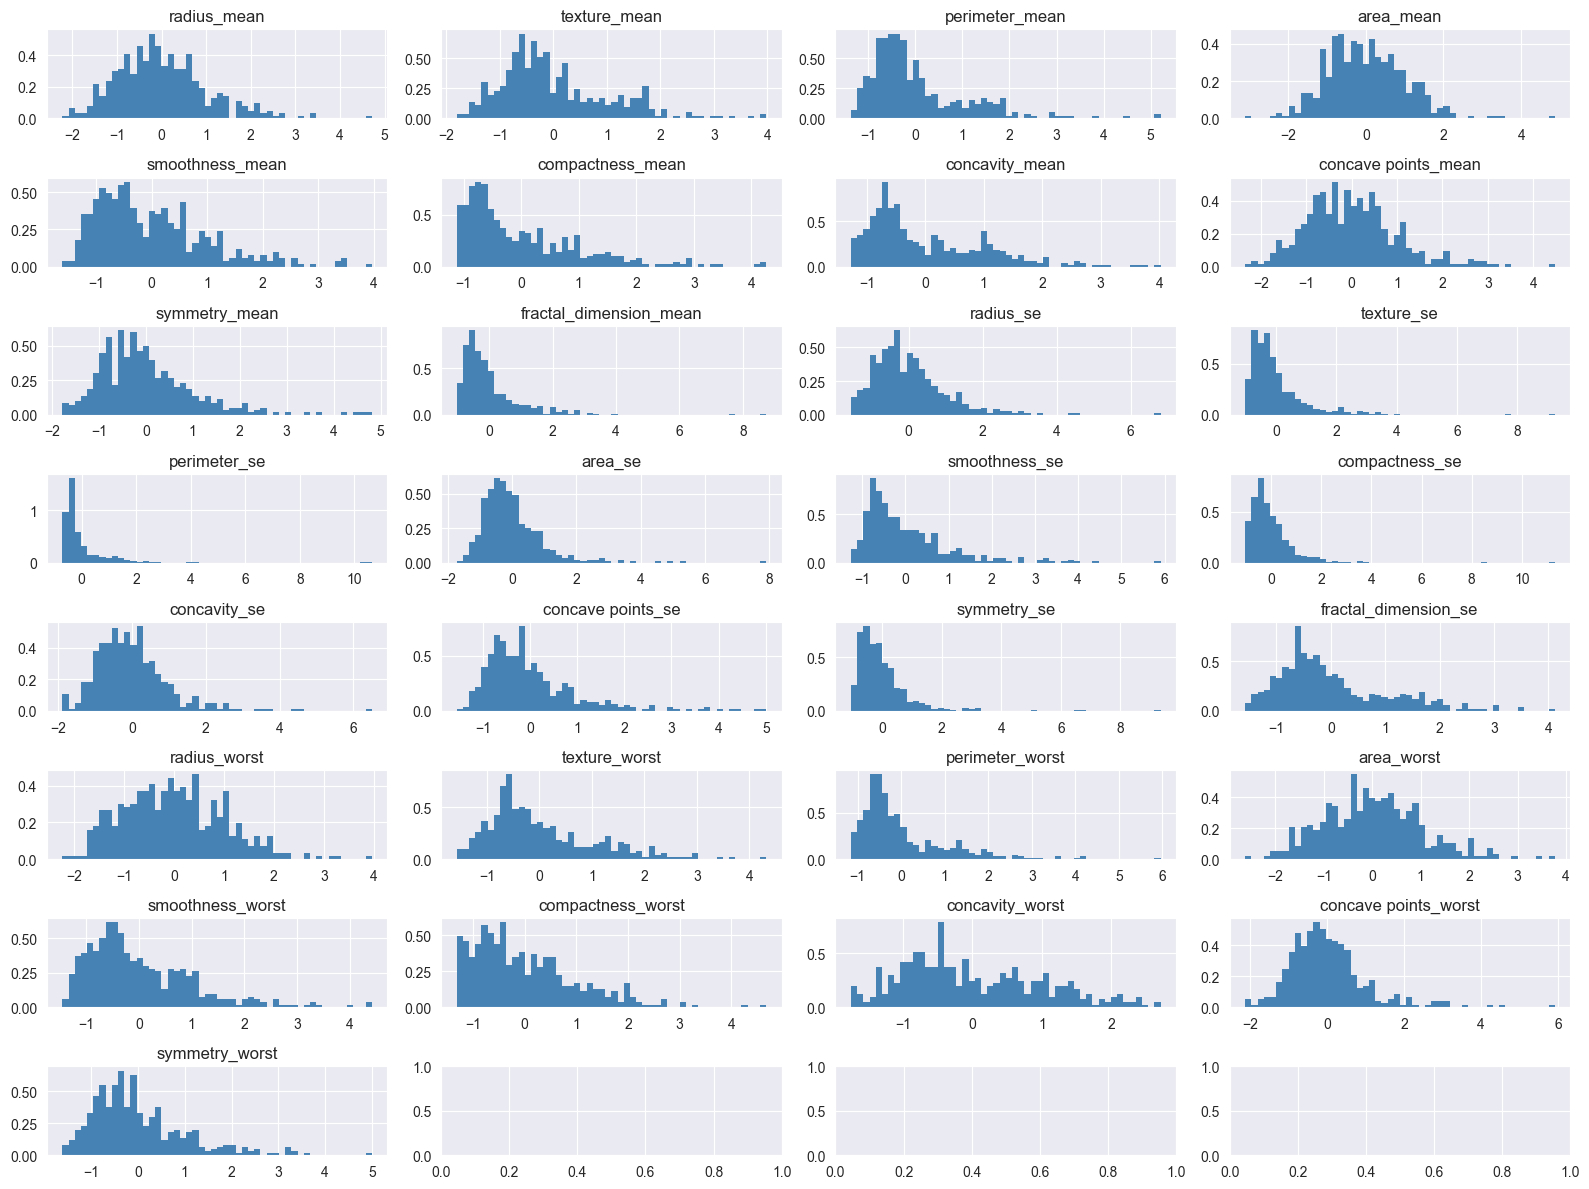

In [100]:
import matplotlib.pyplot as plt

# Création d'une figure contenant plusieurs sous-graphiques disposés en plusieurs lignes et 4 colonnes.
# Le nombre de lignes est calculé dynamiquement en fonction du nombre de caractéristiques de X.
fig, axes = plt.subplots((X.shape[1] + 3) // 4, 4, figsize=(16, 12))

# `axes` est initialement une matrice 2D contenant les sous-graphiques.
# `.flatten()` transforme cette matrice en une liste 1D, ce qui permet d'accéder aux sous-graphiques avec un seul indice (axes[i]).
axes = axes.flatten()

# Boucle à travers toutes les caractéristiques de X_train_std pour tracer leur histogramme.
for feat_idx in range(X_train_std.shape[1]):
    ax = axes[feat_idx]  # Sélectionne le subplot correspondant dans la liste 1D `axes`
    ax.hist(X_train_std[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')  # Histogramme des valeurs normalisées
    ax.set_title(df2.columns[feat_idx + 2])  # Ajoute le titre du graphique correspondant au nom de la colonne

# Ajuste automatiquement l'affichage pour éviter les chevauchements entre les sous-graphiques.
plt.tight_layout()
plt.show()


In [91]:
from sklearn import neighbors, metrics

In [101]:
# Création d'un modèle de recherche d'hyperparamètres (`GridSearchCV`) pour optimiser le nombre de voisins (`n_neighbors`)
# dans l'algorithme K-Nearest Neighbors (KNN).
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(),  # Modèle de classification KNN
    param_grid={"n_neighbors": [3, 5, 7, 9, 11, 13, 15]}  # Liste des valeurs possibles de `n_neighbors` à tester
)

# Définit la métrique de score utilisée pour évaluer les modèles dans la recherche des meilleurs paramètres.
# Ici, on utilise "accuracy", qui mesure le pourcentage de bonnes classifications.
score = 'accuracy'

# Affiche les valeurs uniques de `y_train` pour s'assurer que les labels sont bien formés avant d'entraîner le modèle.
print(np.unique(y_train))  # Devrait afficher uniquement [0, 1] si la conversion des labels a été bien réalisée.


[0 1]


In [102]:
# Entraîne le modèle GridSearchCV sur les données standardisées.
# GridSearchCV teste plusieurs valeurs de `n_neighbors` pour trouver la meilleure configuration.
clf.fit(X_train_std, y_train)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15]})

In [103]:
# Affiche les meilleurs paramètres trouvés par GridSearchCV.
# `best_params_` est un dictionnaire contenant la valeur optimale de `n_neighbors` sélectionnée par validation croisée.
print(clf.best_params_)


{'n_neighbors': 3}


In [104]:
# Boucle à travers les résultats de la validation croisée stockés dans `clf.cv_results_`.
# `zip()` permet de parcourir simultanément plusieurs listes (score moyen, écart-type et paramètres testés).
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # Score moyen obtenu pour chaque valeur de `n_neighbors`
        clf.cv_results_['std_test_score'],  # Écart-type du score obtenu (variation des performances sur les différents folds)
        clf.cv_results_['params']           # Dictionnaire contenant la valeur de `n_neighbors` testée
    ):

    # Affiche les résultats sous forme lisible :
    # Exemple : "accuracy = 0.932 (+/-0.024) for {'n_neighbors': 5}"
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,    # Nom de la métrique utilisée ("accuracy" dans ce cas)
        mean,     # Score moyen obtenu pour cette configuration
        std*2,    # Écart-type multiplié par 2 (correspond à l'intervalle de confiance à 95%)
        params    # Paramètres testés (ex: `{'n_neighbors': 5}`)
    ))


accuracy = 0.963 (+/-0.053) for {'n_neighbors': 3}
accuracy = 0.960 (+/-0.043) for {'n_neighbors': 5}
accuracy = 0.960 (+/-0.049) for {'n_neighbors': 7}
accuracy = 0.956 (+/-0.044) for {'n_neighbors': 9}
accuracy = 0.956 (+/-0.044) for {'n_neighbors': 11}
accuracy = 0.956 (+/-0.037) for {'n_neighbors': 13}
accuracy = 0.956 (+/-0.037) for {'n_neighbors': 15}


In [105]:
# Effectue la prédiction sur les données de test (`X_test_std`) en utilisant le modèle entraîné (`clf`).
y_pred = clf.predict(X_test_std)

# Calcule la précision du modèle en comparant les prédictions (`y_pred`) avec les vraies étiquettes (`y_test`).
# `accuracy_score(y_test, y_pred)` renvoie la proportion de prédictions correctes.
print("\nSur le jeu de test : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))



Sur le jeu de test : 0.947


## Explications :

### `metrics.accuracy_score(y_test, y_pred)`
- Retourne un **score** entre `0` et `1`, représentant la proportion de prédictions correctes.

### Pourquoi c’est utile ?
- Permet de **quantifier la performance** du modèle en pourcentage de bonnes classifications.

### Interprétation des résultats :
- **Proche de 1** (ex: `0.95`) → Le modèle est **très précis**.
- **Proche de 0.5** (ex: `0.55`) → Le modèle **n'est pas fiable** (prédictions proches du hasard).
- **Inférieur à 0.5** → Problème potentiel dans les **données** ou le **modèle**.



In [93]:
# Calcule la précision du modèle en comparant les prédictions (`y_pred`) avec les vraies étiquettes (`y_test`).
# `accuracy_score(y_test, y_pred)` mesure le pourcentage de prédictions correctes.
print(metrics.accuracy_score(y_test, y_pred))


0.9473684210526315


In [110]:
# Création d'une nouvelle donnée à tester (valeurs fictives simulant une tumeur).
# Cette donnée contient **les mêmes caractéristiques** que les données d'entraînement.
# Assure-toi que le nombre de valeurs ici **correspond exactement** au nombre de caractéristiques de X_train_std.
new_sample = np.array([[15.3, 25.1, 102.1, 731.2, 0.1, 0.15, 0.2, 0.1, 0.2, 0.08,
                        0.3, 1.5, 2.1, 32.0, 0.007, 0.05, 0.08, 0.03, 0.02, 0.005,
                        20.5, 30.4, 140.0, 1300.0, 0.12, 0.25, 0.4, 0.15, 0.3]])

# Vérification que la nouvelle donnée a **exactement** le même nombre de caractéristiques que X_train_std.
# Si ce test échoue, c'est qu'il y a un problème avec la taille de new_sample par rapport aux données d'entraînement.
assert new_sample.shape[1] == X_train_std.shape[1], f"Erreur : {new_sample.shape[1]} vs {X_train_std.shape[1]}"

# Applique la transformation standardisée à la nouvelle donnée.
# Le `StandardScaler` a été **ajusté sur X_train_std**, donc ici il transforme `new_sample`
# en utilisant **les mêmes statistiques** (moyenne et écart-type de l'ensemble d'entraînement).
new_sample_std = std_scale.transform(new_sample)

# Utilisation du modèle entraîné (`clf`) pour prédire la classe de `new_sample_std`.
# La sortie `prediction` sera soit **1** (tumeur maligne), soit **0** (tumeur bénigne).
prediction = clf.predict(new_sample_std)

# Affichage du résultat de la prédiction.
# Si la prédiction est `1`, on affiche **"Maligne"**.
# Si la prédiction est `0`, on affiche **"Bénigne"**.
print("Prédiction :", "Maligne" if prediction[0] == 1 else "Bénigne")


Prédiction : Maligne
